# **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **PIP / Imports**

In [ ]:
!pip install cohere
!pip install tiktoken
!pip install openai
!pip install xlsxwriter
!pip install openpyxl
!pip install matplotlib
!pip install scikit-learn
!pip install tqdm

from openpyxl import load_workbook
import xlsxwriter

import os
import sys
import time
from tqdm import tqdm
import openai
import datetime
from openai import OpenAI
import pandas as pd

import numpy as np
from itertools import islice
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import logging


# **Global Variables**

In [ ]:
### MAKE SURE TO CHANGE
curr_LR = "CaseWest"

# Define the path to the Excel file
LR_excel_path = f'/content/drive/MyDrive/LawRevProject/CleanXLSX/Topic/ForTopic_SufficLenSME_wH1-29/{curr_LR}_Topic_SufficLenSME_wH1-29.xlsx'
categories_folder_path = '/content/drive/MyDrive/LawRevProject/CleanXLSX/Topic/CategoriesTexts/'
output_class_xlsx_path_cosine = f'/content/drive/MyDrive/LawRevProject/CleanXLSX/Topic/ForTopic_WithClass-Final/{curr_LR}_Topic_FINAL_Results-cosine.xlsx'
output_class_xlsx_path_euclidean = f'/content/drive/MyDrive/LawRevProject/CleanXLSX/Topic/ForTopic_WithClass-Final/{curr_LR}_Topic_FINAL_Results-euclidean.xlsx'
output_vecs_xlsx_path = f'/content/drive/MyDrive/LawRevProject/CleanXLSX/Topic/ForTopic_WithClass-Final/{curr_LR}_Topic_FINAL_Vectors.xlsx'
output_clusters_xlsx_path = f'/content/drive/MyDrive/LawRevProject/CleanXLSX/Topic/ForTopic_WithClass-Final/{curr_LR}_Topic_FINAL_VecClusters.xlsx'
log_file_path = f'/content/drive/MyDrive/LawRevProject/CleanXLSX/Topic/ForTopic_WithClass-Final/{curr_LR}_Topic_FINAL_Log.txt'

delay = 30

# OpenAI API key
openai.api_key = 'API_KEY'
from openai import OpenAI
client = OpenAI(api_key='API_KEY')
# the model to use
model = "text-embedding-ada-002"


# **Functions**

## Function - Generate a Unique Filename to Prevent Overwrite

In [ ]:
def generate_unique_filename(directory, base_filename, extension):
    counter = 1
    while True:
        # Construct the new filename with a counter if it's greater than 1
        new_filename = f"{base_filename}_{counter}{extension}" if counter > 1 else f"{base_filename}{extension}"
        new_filepath = os.path.join(directory, new_filename)
        # If the file does not exist, we can use this filename
        if not os.path.isfile(new_filepath):
            return new_filepath
        counter += 1


## Function to create embeddings using OpenAI's model


In [ ]:
def create_embeddings(text_content):
    try:
        # Make an API request to generate an embedding
        response = client.embeddings.create(model=model,
                                            input=text_content,
                                            encoding_format="float"
                                            #temperature=0
                                            )
        vec_response = response.data[0].embedding

        # Check if the response has the expected structure
        if len(vec_response) == 1536:
            # Extract the embedding vector from the response
            return vec_response
        else:
            print("Vector's length is less than expected (response<1536).")
            return None

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


## Function - Validate Path Exists


In [ ]:
def verify_path_exists(path):
    """
    Verify whether a path exists.
    It prints a message confirming the existence or non-existence of the path.

    Args:
    path (str): The path to be verified.
    """
    if os.path.exists(path):
        print(f"Directory exists: {path}")
    else:
        print(f"***ERROR*** The following directory does NOT exist: {path}")


## Function - Check If Path Exists, and Create If Not

In [ ]:
def create_dir_if_not_exists(dir_path):
    """
    Create a directory at the specified path if it does not already exist.

    Args:
    directory (str): The path of the directory to be created.
    """
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")
    else:
        print(f"Directory already exists: {dir_path}")

## Function - Create (overwrite) Log File

In [ ]:
def write_log_file(message, log_path):
    """
    Create a log file (and overwrite an existing one).

    Args:
    - message (str): The first message to be logged.
    - log_path (str): Path to the log file where the message will be logged.
    """
    with open(log_path, 'w', encoding='utf-8') as log_file:
        now = datetime.datetime.now()
        log_file.write(f"{now}: {message}")



Function - Add Message to Log File (Does not overwrite)

In [ ]:
def log_error(message, log_path):
    now = datetime.datetime.now()
    with open(log_path, 'a') as log_file:
        print(f"{now}: {message}\n")
        log_file.write(f"{now}: {message}\n\n")

## Function - Visulaizing Clusters Plot

In [ ]:
def plot_clusters(vector_dict, n_clusters):
    # Extract vectors
    names = list(vector_dict.keys())
    vectors = list(vector_dict.values())

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vectors)
    labels = kmeans.labels_

    # Reduce dimensions to 2D for visualization
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    # Plotting
    plt.figure(figsize=(10, 6))
    for i in range(n_clusters):
        # Filter data points that belong to the current cluster
        cluster_points = reduced_vectors[labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

    # Annotate the first items in each category
    for i, name in enumerate(names[:n_clusters]):
        plt.annotate(name, (reduced_vectors[i, 0], reduced_vectors[i, 1]))

    plt.title('Cluster Visualization')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()


## Function - Save Clusters Plot to XLSX

In [ ]:
def cluster_vectors_and_save_to_excel(vector_dict, n_clusters, output_path):
    try:
        # Extract the names and vectors
        names = list(vector_dict.keys())
        vectors = list(vector_dict.values())

        # Perform K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vectors)
        labels = kmeans.labels_

        # Group names by their cluster
        clustered_data = {i: [] for i in range(n_clusters)}
        for name, label in zip(names, labels):
            clustered_data[label].append(name)

        # Write to an Excel file in the specified path
        full_path = output_path
        workbook = xlsxwriter.Workbook(full_path)
        worksheet = workbook.add_worksheet()

        # Iterate over each cluster and write the names to the corresponding column
        for i, (cluster, names) in enumerate(clustered_data.items()):
            worksheet.write(0, i, f'Cluster {i}')
            for row, name in enumerate(names, start=1):
                worksheet.write(row, i, name)

        workbook.close()
        print("Excel file created successfully at:", full_path)
    except Exception as e:
        print("An error occurred:", e)



# **MAIN**

Assigning Categories' Key (Category) and Value (Prompt) to the the Dictionary

In [ ]:
write_log_file("Log started...\n\n\n", log_file_path)

# Dictionary to hold the contents of each SME text file
Cats_and_SMEs_texts_dict = {}

# Iterate through each file in the folder
for filename in os.listdir(categories_folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(categories_folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            Cats_and_SMEs_texts_dict[filename] = content

num_of_categories = len(Cats_and_SMEs_texts_dict)
print("The LR you chose: ", curr_LR)
print("Number of categories: ", num_of_categories)
print(f"The number of items (=currently, only categories) in the dictionary is {num_of_categories}:")
counter_cats = 0
for key in Cats_and_SMEs_texts_dict.keys():
    counter_cats+=1
    print(counter_cats, ". ", key)

###print(Cats_and_SMEs_texts_dict)

The LR you chose:  CaseWest
Number of categories:  29
The number of items (=currently, only categories) in the dictionary is 29:
1 .  Health_CATEGORY.txt
2 .  Bankruptcy_CATEGORY.txt
3 .  Labor & Employment_CATEGORY.txt
4 .  Insurance_CATEGORY.txt
5 .  Contracts_CATEGORY.txt
6 .  Class Actions_CATEGORY.txt
7 .  International Law_CATEGORY.txt
8 .  Criminal_CATEGORY.txt
9 .  Constitutional_CATEGORY.txt
10 .  Evidence & Procedural_CATEGORY.txt
11 .  Competition_CATEGORY.txt
12 .  Immigration_CATEGORY.txt
13 .  Business Orgs_CATEGORY.txt
14 .  Energy & Environment_CATEGORY.txt
15 .  Intellectual Property_CATEGORY.txt
16 .  Banking_CATEGORY.txt
17 .  Family_CATEGORY.txt
18 .  Air & Space_CATEGORY.txt
19 .  Torts_CATEGORY.txt
20 .  Trusts, Estates, Wills_CATEGORY.txt
21 .  Real Estate, Land Use & Zoning_CATEGORY.txt
22 .  Securities_CATEGORY.txt
23 .  Administrative_CATEGORY.txt
24 .  Litigation & Dispute Resolution_CATEGORY.txt
25 .  Property_CATEGORY.txt
26 .  Legal Profession, Writing, Re

Assigning SMEs Texts' Key (Filename) and Value (Content) to the the Dictionary

In [ ]:
# Read the Excel file
df = pd.read_excel(LR_excel_path)

counter_SMEs = 0
total_rows_counter = 0
# Open the log file
with open(log_file_path, 'w') as log_file:
    # Loop through each row in the DataFrame
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing Files", unit="file"):
        SME_path = row['SME']
        curr_cite_line = row['cite_line']
        total_rows_counter+=1

        # Check if the SME_path ends with '_SME.txt'
        if not SME_path.endswith('_SME.txt'):
            error_message = f"Invalid SME value for {curr_cite_line}\n"
            print(error_message)
            log_file.write(error_message)
            continue

        try:
            # Open and read the file content
            with open(SME_path, 'r', encoding='utf-8') as file:
                content = file.read()
                # Add SME_path and content to the dictionary
                Cats_and_SMEs_texts_dict[SME_path] = content
                counter_cats+=1
        except FileNotFoundError:
            error_message = f"Cannot access SME path for {curr_cite_line}\n"
            print(error_message)
            log_file.write(error_message)
        except Exception as e:
            error_message = f"Unknown Problem with {curr_cite_line}: {str(e)}\n"
            print(error_message)
            log_file.write(error_message)


##### Prev Ver
# # Loop through each file in the directory
# for filename in tqdm(os.listdir(SME_dir), desc="Processing Files", unit="file"):
#     # Check if the file ends with '_SME.txt'
#     if filename.endswith('_SME.txt'):
#         # Construct full file path
#         file_path = os.path.join(SME_dir, filename)
#         # Open and read the file content
#         with open(file_path, 'r', encoding='utf-8') as file:
#             content = file.read()
#             # Remove the '.txt' suffix from the filename
#             filename_without_suffix = filename[:-4]
#             # Add filename and content to the dictionary
#             Cats_and_SMEs_texts_dict[filename_without_suffix] = content

Processing Files: 100%|██████████| 2591/2591 [12:52<00:00,  3.36file/s]


In [ ]:
# Calculate the size of the dictionary
dict_size_bytes = sys.getsizeof(Cats_and_SMEs_texts_dict)
dict_size_kb = dict_size_bytes / 1024
# Get the number of items in the dictionary
num_items = len(Cats_and_SMEs_texts_dict)

print(f"The size of the dictionary is approximately {dict_size_kb:.2f} KBs")
print(f"The number of items (TOTAL) in the dictionary is {num_items}")
print(f"(should equal to no. of categories ({num_of_categories}) + ({total_rows_counter}), which is = {num_of_categories+total_rows_counter}))")


The size of the dictionary is approximately 72.09 KBs
The number of items (TOTAL) in the dictionary is 2620
(should equal to no. of categories (29) + (2591), which is = 2620))


In [ ]:
# print one key-value pair
if Cats_and_SMEs_texts_dict:
    # Get the first key-value pair from the dictionary
    first_key, first_value = next(iter(Cats_and_SMEs_texts_dict.items()))
    print(f"Key: {first_key}\nValue: {first_value}")
else:
    print("The dictionary is empty.")


# for key, value in Cats_and_SMEs_texts_dict.items():
#     print(f"{key}: {value}")

# #print all key-value pairs
# for filename, vector in Cats_and_SMEs_texts_dict.items():
#     print(f"Filename: {filename}")
#     print(f"Vector: {vector}\n")


Key: Health_CATEGORY.txt
Value: Health Law Academic Discourse:
Health Law is a dynamic and interdisciplinary field that addresses the legal issues related to the delivery, regulation, and financing of healthcare. It encompasses a broad range of topics, including patient rights, healthcare provider responsibilities, public health policies, and bioethics. The field aims to ensure the provision of safe, effective, and equitable healthcare while balancing the interests of various stakeholders, including patients, providers, insurers, and regulators.
Healthcare Regulation and Compliance Subfield: Healthcare regulation and compliance are critical components of health law, focusing on the legal frameworks that govern healthcare institutions and professionals. This subfield examines the role of federal and state agencies in setting standards, such as the Centers for Medicare & Medicaid Services (CMS) and the Department of Health and Human Services (HHS). Scholarly discussions often revisit key

Generate Embeddings and Assign to a Dictionary

In [ ]:
# Dictionary to hold the filenames as keys and their embedding vectors as values
Cats_and_SMEs_vecs_dict = {}

for i, (file, text) in enumerate(tqdm(Cats_and_SMEs_texts_dict.items(), desc="Processing Texts", unit="text"), 1):
    # Apply the create_embeddings function to the text
    vector = create_embeddings(text)
    # Add the file and vector to the new dictionary
    Cats_and_SMEs_vecs_dict[file] = vector
    # Check if 100 items have been processed
    if i % 100 == 0:
        # Add a delay of 65 seconds
        time.sleep(65)



######### OLD VER, NO DELAY
# # Loop through each item in the Cats_and_SMEs_texts_dict
# for file, text in tqdm(Cats_and_SMEs_texts_dict.items(), desc="Processing Texts", unit="text"):
#     # Apply the create_embeddings function to the text
#     vector = create_embeddings(text)
#     # Add the file and vector to the new dictionary
#     Cats_and_SMEs_vecs_dict[file] = vector


Processing Texts:  53%|█████▎    | 1378/2620 [22:06<07:26,  2.78text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8357 tokens (8357 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  55%|█████▍    | 1429/2620 [23:32<06:04,  3.27text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8343 tokens (8343 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  55%|█████▍    | 1436/2620 [23:35<06:43,  2.93text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8665 tokens (8665 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  58%|█████▊    | 1524/2620 [25:16<06:38,  2.75text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 9161 tokens (9161 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  60%|██████    | 1580/2620 [25:39<05:44,  3.02text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8452 tokens (8452 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  61%|██████    | 1587/2620 [25:42<05:57,  2.89text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8433 tokens (8433 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  61%|██████▏   | 1611/2620 [26:57<12:37,  1.33text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8951 tokens (8951 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  67%|██████▋   | 1743/2620 [28:59<05:30,  2.66text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8738 tokens (8738 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  71%|███████   | 1856/2620 [30:48<04:14,  3.00text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 9072 tokens (9072 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  71%|███████   | 1864/2620 [30:51<03:30,  3.58text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 9949 tokens (9949 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}
An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8678 tokens (8678 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  71%|███████   | 1865/2620 [30:51<02:51,  4.41text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8193 tokens (8193 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  78%|███████▊  | 2040/2620 [34:06<03:17,  2.93text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8553 tokens (8553 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  84%|████████▍ | 2199/2620 [36:15<01:55,  3.63text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8629 tokens (8629 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  94%|█████████▍| 2462/2620 [41:11<00:47,  3.29text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 11223 tokens (11223 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  94%|█████████▍| 2464/2620 [41:11<00:36,  4.27text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 9285 tokens (9285 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts:  94%|█████████▍| 2468/2620 [41:12<00:41,  3.67text/s]

An error occurred: Error code: 400 - {'error': {'message': "This model's maximum context length is 8192 tokens, however you requested 8456 tokens (8456 in your prompt; 0 for the completion). Please reduce your prompt; or completion length.", 'type': 'invalid_request_error', 'param': None, 'code': None}}


Processing Texts: 100%|██████████| 2620/2620 [44:24<00:00,  1.02s/text]


In [ ]:
# #print all key-value pairs
# for filename, vector in Cats_and_SMEs_vecs_dict.items():
#     print(f"Filename: {filename}")
#     print(f"Vector: {vector}")
#     print(f"Vector Ds: {len(vector)}\n")


In [ ]:
# Initialize the counter and list for None type deletions
none_count = 0
none_keys = []

# Filter out None objects from Cats_and_SMEs_vecs_dict
filtered_Cats_and_SMEs_vecs_dict = {}
for key, value in Cats_and_SMEs_vecs_dict.items():
    if value is not None:
        filtered_Cats_and_SMEs_vecs_dict[key] = value
    else:
        none_count += 1
        none_keys.append(key)

# Print the count of None type deletions
print(f'Number of None type deletions: {none_count}')
# Print the list of keys that were deleted
print(f'Keys of None type deletions: {none_keys}')

log_error(f'Number of None type deletions {none_count}', log_file_path)
log_error('Keys of None type deletions:', log_file_path)
for key in none_keys:
    log_error(key, log_file_path)



Number of None type deletions: 17
Keys of None type deletions: ['/content/drive/MyDrive/LawRevProject/Data/CaseWestern Law Rev/SMEText/CaseWest_826_SME.txt', '/content/drive/MyDrive/LawRevProject/Data/CaseWestern Law Rev/SMEText/CaseWest_890_SME.txt', '/content/drive/MyDrive/LawRevProject/Data/CaseWestern Law Rev/SMEText/CaseWest_897_SME.txt', '/content/drive/MyDrive/LawRevProject/Data/CaseWestern Law Rev/SMEText/CaseWest_1008_SME.txt', '/content/drive/MyDrive/LawRevProject/Data/CaseWestern Law Rev/SMEText/CaseWest_1078_SME.txt', '/content/drive/MyDrive/LawRevProject/Data/CaseWestern Law Rev/SMEText/CaseWest_1089_SME.txt', '/content/drive/MyDrive/LawRevProject/Data/CaseWestern Law Rev/SMEText/CaseWest_1121_SME.txt', '/content/drive/MyDrive/LawRevProject/Data/CaseWestern Law Rev/SMEText/CaseWest_1305_SME.txt', '/content/drive/MyDrive/LawRevProject/Data/CaseWestern Law Rev/SMEText/CaseWest_1468_SME.txt', '/content/drive/MyDrive/LawRevProject/Data/CaseWestern Law Rev/SMEText/CaseWest_1488

In [ ]:

################# CREATE XLSX ---- AFTERWARD TRANSFER TO THE END DEPENDING ON THE RESULTS
# Create a new Excel file with filenames and their embedding vectors
workbook = xlsxwriter.Workbook(output_vecs_xlsx_path)
worksheet = workbook.add_worksheet()

# Write the title row
worksheet.write('A1', 'Category OR cite_line')
vector_length = len(next(iter(filtered_Cats_and_SMEs_vecs_dict.values())))
for col in range(vector_length):
    # Excel columns start from 0, but offset by 1 because the first column is 'Filename'
    header_label = f'D {col+1}'
    worksheet.write(0, col+1, header_label)

# Start from the first cell of the next row after the title row
row = 1
# Iterate over the dictionary and write the data to the worksheet
for filename, vector in filtered_Cats_and_SMEs_vecs_dict.items():
    # Write the filename in the first column
    worksheet.write(row, 0, filename)
    # Write the vector values in the rest of the columns
    for col, feature in enumerate(vector, start=1):
        worksheet.write(row, col, feature)
    row += 1

workbook.close()

# Intentional delay
time.sleep(delay)

PCA

In [ ]:
# Convert the dictionary values (vectors) to a NumPy array
all_vectors = np.array(list(filtered_Cats_and_SMEs_vecs_dict.values()))


# Initialize PCA - default to 250 components
# You can choose the number of components based on your needs or by explained variance ratio
#pca = PCA(n_components=250)
pca = PCA(n_components=190)  #  number of files + number of categories has to be > 160



# Fit PCA on the dataset and transform the data
pca_vectors = pca.fit_transform(all_vectors)

# If you want to see how much variance is explained by the components you can print pca.explained_variance_ratio_
explained_PCAed_list = pca.explained_variance_ratio_
explained_PCAed_list_percentage = [var_ratio * 100 for var_ratio in explained_PCAed_list]
print(explained_PCAed_list_percentage)

# Print each component's explained variance as a percentage
for i, var_percent in enumerate(explained_PCAed_list_percentage, start=1):
    print(f"Component {i}: {var_percent:.2f}%")

# Calculate and print the sum of the percentages
sum_of_percentages = sum(explained_PCAed_list_percentage)
print(f"Sum of explained variance percentages: {sum_of_percentages:.2f}%\n\n")


# Now, pca_vectors is a NumPy array with reduced dimensionality
# Convert pca_vectors back to a dictionary with the same keys:
SMEs_PCA_vecs_dict = {filename: vec.tolist() for filename, vec in zip(filtered_Cats_and_SMEs_vecs_dict.keys(), pca_vectors)}

#for key, pca_vector in SMEs_PCA_vecs_dict.items():
#    print(f"Key: {key}")
#    print(f"PCA Vector: {pca_vector}\n")

[5.049197634814642, 3.863635971849895, 2.8654101962520264, 2.376316493208071, 2.0635001308978747, 1.781368187496367, 1.659916098666217, 1.562235923894377, 1.4379908209367716, 1.3354427533133932, 1.2577919147716639, 1.1332088081522689, 1.0905188115726827, 1.0587595955322655, 0.9746351253267983, 0.9463421270439957, 0.9214751714175734, 0.8899814442252869, 0.8101724566190852, 0.7935095888514127, 0.7688838588772272, 0.7374730170032098, 0.7257991418052887, 0.7145857747618976, 0.6459834340579816, 0.6400585856641507, 0.6113860545976705, 0.5804170160414641, 0.5744121597739025, 0.5640512135314415, 0.547411541639935, 0.5375975898256163, 0.5342115861259814, 0.5106840880164433, 0.5054331876997611, 0.5014366707397907, 0.4775279231268259, 0.4767935273090309, 0.4657322212850353, 0.4616684112130975, 0.4526795631010625, 0.44601005394981647, 0.43530708677609914, 0.4284024176602255, 0.41785954039820883, 0.4128286731321065, 0.40707419820518403, 0.3953371130459694, 0.3873321715179285, 0.38217485322290273, 0

Clustering (plot + save to xlsx)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


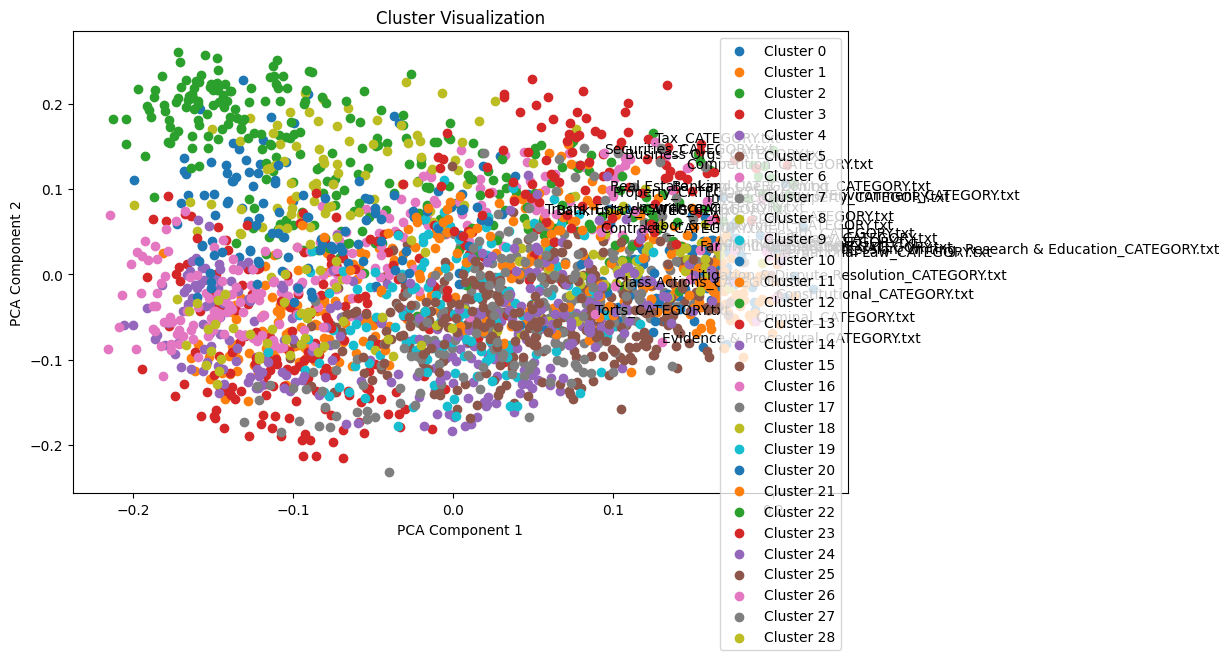

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Excel file created successfully at: /content/drive/MyDrive/LawRevProject/CleanXLSX/Topic/ForTopic_WithClass-Final/CaseWest_Topic_FINAL_VecClusters.xlsx


In [ ]:
# Plot clustering
n_clusters = num_of_categories  # Set the number of clusters
plot_clusters(SMEs_PCA_vecs_dict, n_clusters)

# Create xlsx of the clustering
n_clusters = num_of_categories  # Set the number of clusters
cluster_vectors_and_save_to_excel(SMEs_PCA_vecs_dict, n_clusters, output_clusters_xlsx_path)


Separating Categories and Texts + Vectors Normalization

In [ ]:
######## UNIFIED INTO THE NEXT-NEXT BOX, WITH THE WRITING OF SCORES AND CATS
# # Extract category vectors and text vectors
# category_keys = list(SMEs_PCA_vecs_dict)[:num_of_categories]
# category_vectors = np.array([SMEs_PCA_vecs_dict[key] for key in category_keys])

# text_keys = list(SMEs_PCA_vecs_dict)[num_of_categories:]
# text_vectors = np.array([SMEs_PCA_vecs_dict[key] for key in text_keys])

# # Normalize the vectors
# category_vectors_normalized = category_vectors / np.linalg.norm(category_vectors, axis=1, keepdims=True)
# text_vectors_normalized = text_vectors / np.linalg.norm(text_vectors, axis=1, keepdims=True)


Calculate Cosine + Save to XLSX

In [ ]:
####### ORIGINAL VERS - ALTERNATIVE BELOW
# # Calculate cosine similarity
# cosine_similarities = cosine_similarity(text_vectors_normalized, category_vectors_normalized)

# # Write cosine similarities scores to an XLSX file
# workbook = xlsxwriter.Workbook(output_class_xlsx_path_cosine)
# worksheet = workbook.add_worksheet()
# worksheet.write_row('A1', ['Text Key'] + category_keys)
# for i, text_key in enumerate(text_keys):
#     worksheet.write_row(i+1, 0, [text_key] + list(cosine_similarities[i]))
# workbook.close()


UNIFIED: Calculate Cosine + Save to XLSX + Separating Categories and Texts + Vectors Normalization --> ALL TO NEW XLSX WITH ALL H1-29 AND CATS PREDICTION

In [ ]:
# Ensure required columns are present
required_columns = ['SME'] + [f'ClassH{i}_Score' for i in range(1, 30)] + [f'ClassH{i}_Topic' for i in range(1, 30)]
for col in required_columns:
    if col not in df.columns:
        log_error(f'Column {col} not found in the xlsx.', log_file_path)
        raise ValueError(f'Column {col} not found in the xlsx.')

# Extract category and text vectors
category_keys = list(SMEs_PCA_vecs_dict)[:num_of_categories]
category_vectors = np.array([SMEs_PCA_vecs_dict[key] for key in category_keys])

text_keys = list(SMEs_PCA_vecs_dict)[num_of_categories:]
text_vectors = np.array([SMEs_PCA_vecs_dict[key] for key in text_keys])

# Normalize the vectors
category_vectors_normalized = category_vectors / np.linalg.norm(category_vectors, axis=1, keepdims=True)
text_vectors_normalized = text_vectors / np.linalg.norm(text_vectors, axis=1, keepdims=True)

# Calculate cosine similarities
cosine_similarities = cosine_similarity(text_vectors_normalized, category_vectors_normalized)

# Create a copy of the original Excel file to save the modifications
writer = pd.ExcelWriter(output_class_xlsx_path_cosine, engine='xlsxwriter')
df.to_excel(writer, index=False, sheet_name='Sheet1')
workbook = writer.book
worksheet = writer.sheets['Sheet1']

# Get the column indices for SME, ClassH1_Score, etc.
SME_col = df.columns.get_loc('SME')
class_score_cols = [df.columns.get_loc(f'ClassH{i}_Score') for i in range(1, 30)]
class_topic_cols = [df.columns.get_loc(f'ClassH{i}_Topic') for i in range(1, 30)]

# Update the similarities and categories in the new Excel file
for i, text_key in enumerate(text_keys):
    try:
        # Find the respective row for the current text key
        text_row = df.index[df['SME'] == text_key].tolist()
        if not text_row:
            log_error(f'Text key {text_key} not found in the xlsx under SME.', log_file_path)
            continue

        text_row = text_row[0]
        similarities = cosine_similarities[i]

        # Sort categories by similarity scores in descending order
        sorted_indices = np.argsort(similarities)[::-1]

        # Write the top similarities and their respective categories
        for j in range(num_of_categories):
            category_index = sorted_indices[j]
            score = similarities[category_index]
            category_key = category_keys[category_index]

            worksheet.write(text_row + 1, class_score_cols[j], score)
            worksheet.write(text_row + 1, class_topic_cols[j], category_key)

    except Exception as e:
        log_error(f'Error processing text key {text_key}: {e}', log_file_path)

# Save the new Excel file
writer.close()


Calculate Euclidean + Save to XLSX

In [ ]:
###### SEEMS LIKE NOT NEEDED - BECAUSE COSINE WORKS HERE BETTER THAN EUCLIDEAN
# # Calculate Euclidean distance
# euclidean_distances = np.array([[distance.euclidean(tv, cv) for cv in category_vectors_normalized] for tv in text_vectors_normalized])

# # Write Euclidean distances to an XLSX file
# workbook = xlsxwriter.Workbook(output_class_xlsx_path_euclidean)
# worksheet = workbook.add_worksheet()
# worksheet.write_row('A1', ['Text Key'] + category_keys)
# for i, text_key in enumerate(text_keys):
#     worksheet.write_row(i+1, 0, [text_key] + list(euclidean_distances[i]))
# workbook.close()


In [ ]:
similarities_matrix_path = f'/content/drive/MyDrive/LawRevProject/CleanXLSX/Topic/ForTopic_WithClass-Final/{curr_LR}_Topic_ALL_Similarities-cosine.xlsx'

# Convert the cosine similarities matrix to a DataFrame
similarities_df = pd.DataFrame(cosine_similarities, index=text_keys, columns=category_keys)

# Save the DataFrame to an Excel file
with pd.ExcelWriter(similarities_matrix_path, engine='xlsxwriter') as similarities_writer:
    similarities_df.to_excel(similarities_writer, index=True, sheet_name='Similarities')

print(f"Saved similarities matrix to {similarities_matrix_path}")

Saved similarities matrix to /content/drive/MyDrive/LawRevProject/CleanXLSX/Topic/ForTopic_WithClass-Final/CaseWest_Topic_ALL_Similarities-cosine.xlsx


In [ ]:
log_error("\n\n\nCode run has finished; If you haven't yet, consider exporting to XLSX.", log_file_path)

2024-07-16 15:42:01.824410: 


Code run has finished; If you haven't yet, consider exporting to XLSX.



ONLY AFTER FINISHING, RUN TO CREATE VECS XLSX

Create a Vectors XLSX file